In [5]:
import numpy as np
import matplotlib.pyplot as plt

This tutorial is strongly based on https://celerite.readthedocs.io/en/stable/tutorials/first/

 # Load sample data

Our first step will be to load sample data. I've hidden that in a separate script, but suffice it to say, it follows a functional form I know. 

In [6]:
true_t = np.load("true_vals.npy")[0]
true_y = np.load("true_vals.npy")[1]

In [7]:
t = np.load("meas_vals.npy")[0]
y = np.load("meas_vals.npy")[1]
yerr = np.load("meas_vals.npy")[2]

Text(0.5, 1.0, 'Sample Data')

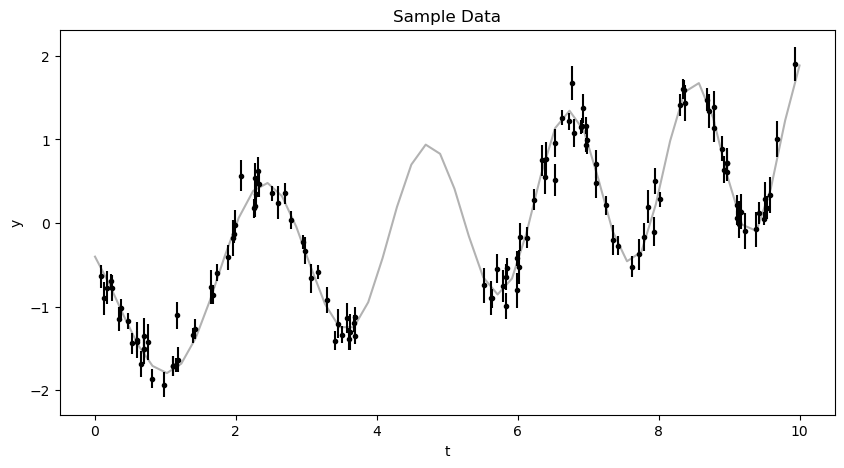

In [8]:
plt.figure(figsize=[10,5])
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("t")
plt.ylabel("y")
plt.title('Sample Data')

In [9]:
import celerite
from celerite import terms

# We would like a Gaussian Process Model for this function

So what should we do? Let's build a kernel! 


Let's start with a basic exponential kernel. How would we build that?

Check out the celerite documentation here: https://celerite.readthedocs.io/en/stable/python/kernel/

In [10]:
expkern = 

SyntaxError: invalid syntax (1058979344.py, line 1)

Now make an individual Gaussian Process. It'snot very useful in its own right, but it's a good cross-check.

In [ ]:
expgp = celerite.GP(expkern,mean=np.mean(y))
expgp.compute(t, yerr) 

Very quickly, let's take a look at what values it's predicting.

In [ ]:
exp_x = np.linspace(0, 10, 5000)
exp_pred_mean, exp_pred_var = expgp.predict(y, exp_x, return_var=True)
exp_pred_std = np.sqrt(exp_pred_var)

In [ ]:
plt.figure(figsize=[10,5])
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, exp_pred_mean, color=color)
plt.fill_between(x, exp_pred_mean+exp_pred_std, exp_pred_mean-exp_pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")



This looks pretty good, but is it really? Could we do better?


In [ ]:
print("Initial log likelihood: {0}".format(expgp.log_likelihood(y)))

Hmmm. It looked okay at first but it seems like we don't really have a good model, once we look at the prediction value.

We need a better way to assess what we have. Enter: the Cost Function

In [11]:
# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]


In [12]:
from scipy.optimize import minimize

In [ ]:
# Fit for the maximum likelihood parameters
initial_params = expgp.get_parameter_vector()
bounds = expgp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, expgp))
expgp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

In [1]:
# Make the maximum likelihood prediction
t = np.linspace(0, 10, 500)
mu, var = expgp.predict(y, t, return_var=True)
std = np.sqrt(var)


NameError: name 'np' is not defined

In [ ]:
# Do an MCMC Sampler

In [ ]:
def exp_log_probability(params):
    expgp.set_parameter_vector(params)
    lp = expgp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return expgp.log_likelihood(y) + lp

In [ ]:
import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, exp_log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

In [ ]:
z = np.linspace(0,10,len(y))

In [ ]:
plt.figure(figsize=[10,5])
# Plot the data.
plt.errorbar(z, y, yerr=yerr, fmt=".k", capsize=0)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    expgp.set_parameter_vector(s)
    mu = expgp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");



So what do you think?

# Stochastic Harmonic Oscillator-based kernel

Let's try a model that's based on the stochastic harmonic oscillator kernel function (a built-in in Celerite).

In [ ]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [ ]:
# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [ ]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Find best fit params

In [ ]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [ ]:
plt.figure(figsize=[10,5])
color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("t")
plt.ylabel("y")



In [ ]:
# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

In [ ]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp


In [ ]:


import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);



In [ ]:
z = np.linspace(0,10,len(y))

In [ ]:
len(y)

In [ ]:
# Plot the data.
plt.errorbar(z, y, yerr=yerr, fmt=".k", capsize=0)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

# Next Steps

Take this "pretty good" model and implement MCMC fitting. Create many, many Gaussian processes & come up with a true estimate for how well we can fit.